# VQA

Visual Question Answering

Given a picture and a question, net must predict an answer

Net structure:

    1) image representation using vgg
    2) text representation w2v (word to vector)
    3) classifier


In [0]:
 #Dependecies
from IPython.display import clear_output

import pandas as pd
import numpy as np
import re

from gensim.models import KeyedVectors

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torchvision.models as models

from cv2 import resize, imread, imshow
from PIL.Image import open as im_open

from matplotlib import pyplot as plt

import copy

In [0]:
!rm -r *
# Word2vec .bin
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz
!rm GoogleNews-vectors-negative300.bin.gz
# DAQUAR images
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar
!tar -xvf nyu_depth_images.tar
!rm nyu_depth_images.tar
# qa pairs train
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.train.txt
# qa pairs test
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.test.txt
clear_output()

(I)mage, (Q)uestion, (A)nswer dataset preparation

In [0]:
def iqa_dataset(filename):
    iqa = open(filename, 'r')
    iqa = list(iqa)
    data = []
    for i in range (0, len(iqa), 2):
        q = iqa[i][:-1]
        # if answer consists more than 2 words, it was separated by _, made it be separated by space
        a = iqa[i+1][:-1].replace("_", " ")
        # find name of image
        im = re.findall("image[0-9]+", q)[-1]
        # delete the image name from question
        q = q.split("in the image")[0]
        # there are answers that are divided by commas, made them different rows of data
        for lil_a in a.split(", "):
            data += [[im, q, lil_a]]
    return pd.DataFrame(np.array(data), columns=["image", "question", "answer"])

In [ ]:
#train val test data split
train_data = iqa_dataset("qa.894.raw.train.txt")
test_data = iqa_dataset("qa.894.raw.test.txt")

train_data = train_data[:int(len(train_data)*0.8)]
val_data = train_data[int(len(train_data)*0.8):]

# vocabulary of answers
vocab = np.unique(np.append(train_data["answer"].values, 
                             test_data["answer"].values))

In [0]:
print(train_data.shape)
train_data.head()

In [0]:
print(val_data.shape)
val_data.head()

In [0]:
print(test_data.shape)
test_data.head()

(6562, 3)


,image,question,answer
0,image1,what is on the left side of the white oven on ...,garbage bin
1,image1,what is on the left side of the fire extinguis...,table
2,image1,what is between the the two white and black ga...,chair
3,image1,how many objects are between the fire extingui...,3
4,image1,what is the largest object in this picture,washing machine


In [0]:
print(vocab.shape)
sorted(vocab)

(561,)


['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '18',
 '19',
 '2',
 '2163',
 '22',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'air conditioner',
 'air vent',
 'alarm',
 'alarm clock',
 'album',
 'aluminium foil',
 'apple',
 'ashtray',
 'baby chair',
 'baby gate',
 'back scrubber',
 'backpack',
 'bag',
 'ball',
 'balloon',
 'banana',
 'banister',
 'bar of soap',
 'basket',
 'basketball',
 'basketball hoop',
 'bathtub',
 'bean bag',
 'bed',
 'bed sheets',
 'bench',
 'bicycle',
 'bin',
 'binder',
 'black',
 'blackboard',
 'blanket',
 'blender',
 'blinds',
 'blue',
 'board',
 'book',
 'book holder',
 'bookrack',
 'books',
 'bookshelf',
 'bottle',
 'bottle of hand wash liquid',
 'bottle of liquid',
 'bottle of listerine',
 'bottle of perfume',
 'bottle of soap',
 'bowl',
 'box',
 'box of paper',
 'bread',
 'brick',
 'briefcase',
 'broom',
 'brown',
 'bucket',
 'bulb',
 'bunk bed',
 'business cards',
 'cabinet',
 'cable box',
 'cables',
 'calculator',
 'calendar',
 'can',
 'can of be

## model


Word2vector and vgg for exraction question and image features 

In [4]:
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def sent2vec(sent):
    """
    Using w2v converts sentence to vector
    input: sentence
    """
    output = []
    for word in sent.split():
        try:
            output += [w2v[word]]
        except:
            continue
    return np.mean(output, 0)

def to_vocab(a):
    """
    answer converts to index of word in vocabulary
    """
    return torch.tensor([int(np.where(vocab==aa)[0]) for aa in a])

def from_one_hot(output):
    """
    net's one-hot-like output converts to number of class (index in vocabulary) 
    """
    return torch.tensor([(oo == torch.max(oo)).nonzero() for oo in output])

In [0]:
def prepare_data(batch_size, df):
    """
    preparing data from dataframe
    """
    data = df.values
    for i in range(0, len(data), batch_size):
        data = np.roll(data, batch_size, axis= 0)
        batch = data[:batch_size]
        try:
            batch[:, 0] = [np.array(im_open("nyu_depth_images/{}.png".format(f)))/255 for f in batch[:, 0]]
        except:
            continue
        batch[:, 0] = [resize(img, (112,85)) for img in batch[:,0]]
        yield batch

In [0]:
class Baseline(nn.Module):
    """
    Baseline contain two network
    1) image representation using vgg
    2) text representation w2v
    3) pass such vector through classifier
    """
    def __init__(self, vocab, dropout):
        super().__init__()
        
        self.vocab_size = len(vocab)
        self.dropout = dropout
        
        self.text_net = sent2vec
        self.image_net = vgg.features
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(3372), #2348 if (64,64)

            nn.Linear(3372, 1024), #512*13*17+300
         
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 561),
       )
    def forward(self, x):
        """
        x[0] is an image, x[1] is question
        """
        im_features = self.image_net(x[0])
        txt_features = torch.from_numpy(np.array([self.text_net(sent) for sent in x[1]]))
        sh = im_features.shape
        im_features = im_features.view(sh[0], sh[1]*sh[2]*sh[3])
        features = torch.cat((im_features, txt_features.cuda()), 1)
        del txt_features, im_features
        output = self.classifier(features)
        output = F.softmax(output, dim=1)
        return output

In [0]:
def train(net, train_data, val_data, epochs=10, batch_size=4, lr=0.001, print_every=100, clip=3):    
    net.train()
    opt = torch.optim.Adam(net.parameters(), lr=lr) #______________
    criterion =  nn.CrossEntropyLoss()#<CE> _____________ 

    net.text_net.requires_grad = False
    net.image_net.requires_grad = False
    counter = 0
    n = net.vocab_size
    best_acc = 0
    for e in range(epochs):
        train_gen = prepare_data(batch_size, train_data)
        val_losses = []
        losses = []
        val_acc = []
        acc = []
        net.eval()
        
        # Get validation loss
        val_gen = prepare_data(batch_size, val_data)
        for batch in val_gen:
            im_t = batch[:,0]
            q_t = batch[:,1]
            a_t = batch[:,2]
            im_t = torch.from_numpy(np.array([list(i) for i in im_t])).float()
            if im_t.shape[1]!=3:
                im_t = im_t.view(batch_size, 3, im_t.shape[1], im_t.shape[2])
            im_t = im_t.cuda()
            # forward

            val_output = net.forward([im_t, q_t])
            a_t = to_vocab(a_t).cuda()
            # count accuracy
            accuracy = 1 - np.count_nonzero(from_one_hot(val_output)-a_t.cpu())/batch_size
            val_acc.append(accuracy)
            
            del im_t
            
            val_loss = criterion(val_output, a_t)
            val_losses.append(val_loss.item())
        
        # best model
        if np.mean(val_acc)>best_acc:
            best_acc = np.mean(val_acc)
            best_model = copy.deepcopy(net)
            torch.save(best_model, "best_model.pth")
            print("\nBest model at the moment!!!!!!!!!!!!!!!!!!!!!")
        
        # information
        print("\nEpoch: {}/{}...".format(e+1, epochs),
              "\tVal Loss: {:.4f}".format(np.mean(val_losses)),
              "\tVal Acc: {:.4f}\n".format(np.mean(val_acc)))
        
        net.train()
        for batch in train_gen:
            counter += 1
            im = batch[:,0]
            q = batch[:,1]
            
            a = batch[:,2]
            
            im = torch.from_numpy(np.array([list(i) for i in im])).float()
            if im.shape[1]!=3:
                im = im.view(batch_size, 3, im.shape[1], im.shape[2]).cuda()

            net.zero_grad()
            # forward
            output = net.forward([im, q])
            del im
            a = to_vocab(a).cuda()
            
            # count accuracy
            accuracy = 1 - np.count_nonzero(from_one_hot(output)-a.cpu())/batch_size
            acc.append(accuracy)
            # loss
            loss = criterion(output, a)
            loss.backward()

            nn.utils.clip_grad_norm_(net.parameters(), clip)
            
            losses.append(loss.item())
            opt.step()
            
            #information
            if counter % print_every == 0:
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "\tStep: {}...".format(counter),
                      "\tMin loss: {:.4f}".format(np.min(losses)),
                      "\tMax loss: {:.4f}".format(np.max(losses)),
                      "\tLoss: {:.4f}...".format(np.mean(losses)),
                      "\tAcc: {:.4f}".format(np.mean(acc)))
                losses = []

    return net

In [0]:
if 'model' in locals():
    del model
torch.cuda.empty_cache()

model = torch.load('best_model.pth') #Baseline(vocab, dropout = 0.3)
model.cuda()
clear_output()

In [23]:
BATCH_SIZE = 32
train(model, train_data, val_data, epochs=30, batch_size=BATCH_SIZE, lr=0.001, print_every=10)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Baseline. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Best model at the moment!!!!!!!!!!!!!!!!!!!!!

Epoch: 1/30... 	Val Loss: 6.0503 	Val Acc: 0.3067

Epoch: 1/30... 	Step: 10... 	Min loss: 6.0209 	Max loss: 6.1395 	Loss: 6.0850... 	Acc: 0.2687
Epoch: 1/30... 	Step: 20... 	Min loss: 5.8397 	Max loss: 6.1977 	Loss: 6.0800... 	Acc: 0.2734
Epoch: 1/30... 	Step: 30... 	Min loss: 5.9666 	Max loss: 6.2356 	Loss: 6.1272... 	Acc: 0.2542
Epoch: 1/30... 	Step: 40... 	Min loss: 5.9182 	Max loss: 6.2491 	Loss: 6.1338... 	Acc: 0.2406
Epoch: 1/30... 	Step: 50... 	Min loss: 5.9947 	Max loss: 6.2951 	Loss: 6.1461... 	Acc: 0.2331
Epoch: 1/30... 	Step: 60... 	Min loss: 6.0227 	Max loss: 6.2030 	Loss: 6.1066... 	Acc: 0.2349
Epoch: 1/30... 	Step: 70... 	Min loss: 6.0075 	Max loss: 6.2317 	Loss: 6.1326... 	Acc: 0.2308
Epoch: 1/30... 	Step: 80... 	Min loss: 5.9915 	Max loss: 6.2428 	Loss: 6.1306... 	Acc: 0.2285
Epoch: 1/30... 	Step: 90... 	Min loss: 6.0523 	Max loss: 6.2263 	Loss: 6.1482... 	Acc: 0.2243
Epoch: 1/30... 	Step: 100... 	Min loss: 6.0845 	Max los

Baseline(
  (image_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): 

In [0]:
torch.save(model, 'model0.pth')
the_model = torch.load('best_model.pth')
the_model.eval()

Counting accuracy on test data

In [21]:
b_gen = prepare_data(1, test_data)
accuracy = 0
for batch in b_gen:
    im = batch[:,0]
    q = batch[:,1]
    a = batch[:,2]
    im = torch.from_numpy(np.array([list(i) for i in im])).float()
    if im.shape[1]!=3:
        try:
            im = im.view(1, 3, im.shape[1], im.shape[2]).cuda()
        except:
            pass
    output = the_model.forward([im, q])
    if vocab[int(from_one_hot(output))] == a[0]:
        accuracy += 1
accuracy/=len(test_data)
print(accuracy)

0.15985979884181653


Visualization of prediction

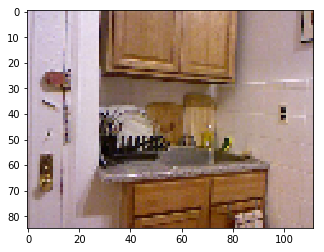

Question: what are the wooden objects in this picture 
Model answer: sofa
Real answer: cabinet


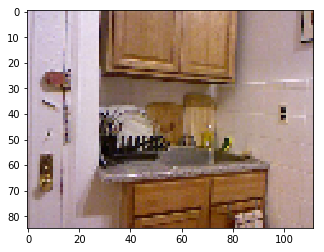

Question: what color is the dish washing sponge close to the sink 
Model answer: white
Real answer: yellow


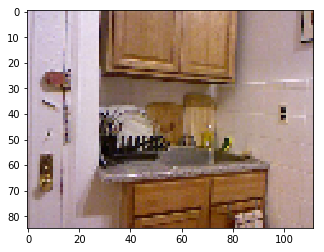

Question: what color is the dish washing sponge close to the sink 
Model answer: white
Real answer: green


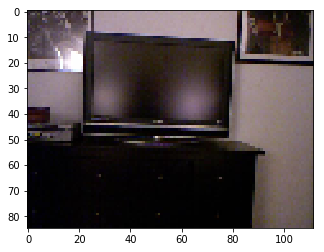

Question: what is below the television 
Model answer: table
Real answer: dresser


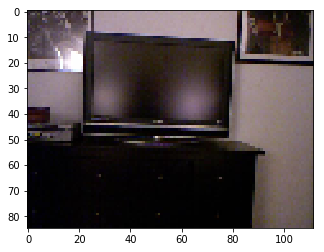

Question: how many frames are on the wall 
Model answer: 3
Real answer: 2


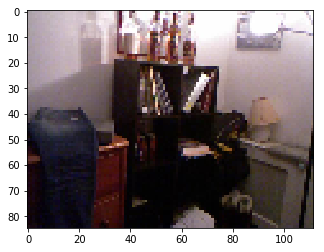

Question: how many lamps are on in this picture 
Model answer: 2
Real answer: 1


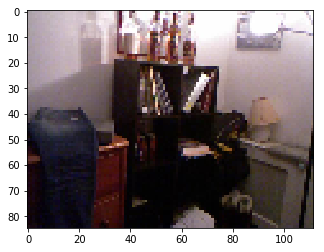

Question: what is below the blue jean 
Model answer: white
Real answer: box


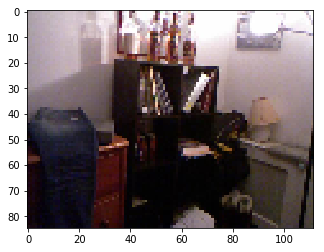

Question: what is below the blue jean 
Model answer: white
Real answer: desk


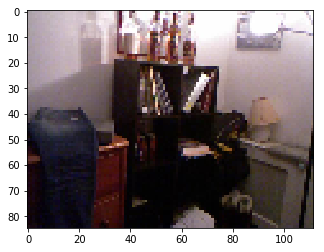

Question: how many bottles are on the top pf the bookcase 
Model answer: 3
Real answer: 4


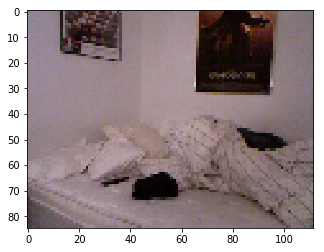

Question: how many black objects are on the bed 
Model answer: pillow
Real answer: 3


In [27]:
batch_gen = prepare_data(1, test_data[105:115])
for batch in batch_gen:
    im = batch[:,0]
    plt.imshow(im[0])
    plt.show()
    q = batch[:,1]
    a = batch[:,2]

    im = torch.from_numpy(np.array([list(i) for i in im])).float()
    if im.shape[1]!=3:
        try:
            im = im.view(1, 3, im.shape[1], im.shape[2]).cuda()
        except:
            pass
    output = the_model.forward([im, q])
    print("Question: {}".format(q[0]))
    print("Model answer: {}".format(vocab[int(from_one_hot(output))]))
    print("Real answer: {}".format(a[0]))

Accuracy 16%